## Neural Networks 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from pathlib import Path

2025-05-03 20:58:54.288742: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Neural Networks

In [2]:
def run_keras_tuner(X_dict, y_dict, 
                    n_splits=5, 
                    max_trials=10, 
                    executions_per_trial=1,
                    epochs=60, 
                    batch_size=16,
                    random_state=42):
    """
    Run Keras Tuner hyperparameter search with K-Fold cross-validation
    over multiple feature sets.

    Parameters:
    -----------
    X_dict : dict[str, np.ndarray]
        Dictionary mapping feature-set names to feature matrices of shape (n_samples, n_features).
    y : np.ndarray
        Label vector of shape (n_samples,).
    n_splits : int
        Number of folds for K-Fold CV.
    max_trials : int
        Number of hyperparameter trials per fold.
    executions_per_trial : int
        Number of model builds per trial.
    epochs : int
        Maximum number of epochs for training.
    batch_size : int
        Batch size for training.
    random_state : int
        Seed for reproducibility in KFold splitting.

    Returns:
    --------
    results : dict
        For each feature-set name, returns a dict with:
          - "cv_scores": list of fold accuracies
          - "mean_acc": mean accuracy across folds
          - "std_acc": std of accuracies
          - "best_model": retrained model on full data with best hyperparameters
          - "best_hps": HyperParameters object of the best trial from the last fold
          - "histories": list of training History objects (one per fold)
    """
    results = {}

    # Prepare cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for name, X in X_dict.items():
        print(f"\n=== Feature set: {name} ===")
        fold_scores = []
        histories = []
        best_hps_last = None

        y = y_dict[name]
        num_classes = len(np.unique(y))

        # Iterate folds
        for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
            print(f"\n-- Fold {fold}/{n_splits} --")
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr, y_val = y[train_idx], y[val_idx]
            # One-hot encode
            y_tr_ohe = tf.keras.utils.to_categorical(y_tr, num_classes)
            y_val_ohe = tf.keras.utils.to_categorical(y_val, num_classes)

            # Early stopping
            early_stop = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            )

            # Model builder for tuner
            def model_builder(hp):
                model = tf.keras.Sequential()
                model.add(tf.keras.layers.Input(shape=(X_tr.shape[1],)))

                # Dense layer
                units1 = hp.Int('units_1', 32, 128, step=32)
                model.add(tf.keras.layers.Dense(units1, kernel_initializer='he_normal'))
                model.add(tf.keras.layers.BatchNormalization())
                model.add(tf.keras.layers.Activation('relu'))

                # Optional second layer
                if hp.Boolean('add_second_layer'):
                    units2 = hp.Int('units_2', 32, 64, step=16)
                    model.add(tf.keras.layers.Dense(units2, kernel_initializer='he_normal'))
                    model.add(tf.keras.layers.BatchNormalization())
                    model.add(tf.keras.layers.Activation('relu'))

                # Dropout
                dropout = hp.Float('dropout', 0.2, 0.4, step=0.1)
                model.add(tf.keras.layers.Dropout(dropout))

                # Output
                model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

                # Optimizer
                lr = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])
                model.compile(
                    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )
                return model

            # Initialize tuner
            tuner = kt.RandomSearch(
                model_builder,
                objective='val_accuracy',
                max_trials=max_trials,
                executions_per_trial=executions_per_trial,
                directory='keras_tuner_dir',
                project_name=f'{name}_fold{fold}'
            )

            # Hyperparameter search on this fold
            tuner.search(
                X_tr, y_tr_ohe,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_val, y_val_ohe),
                callbacks=[early_stop],
                verbose=2
            )

            # Get best hyperparameters for this fold
            best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
            best_hps_last = best_hps  # keep last to retrain on full data later

            # Build and train best model on this fold
            model = tuner.hypermodel.build(best_hps)
            history = model.fit(
                X_tr, y_tr_ohe,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_val, y_val_ohe),
                callbacks=[early_stop],
                verbose=0
            )
            histories.append(history)

            # Evaluate on validation split
            val_preds = model.predict(X_val)
            val_labels = np.argmax(val_preds, axis=1)
            acc = accuracy_score(y_val, val_labels)
            print(f"Fold {fold} accuracy: {acc:.4f}")
            fold_scores.append(acc)

        # Summarize CV results
        mean_acc = np.mean(fold_scores)
        std_acc = np.std(fold_scores)
        print(f"\n{name} — CV mean acc: {mean_acc:.4f} ± {std_acc:.4f}")

        # Retrain best model on full dataset
        y_ohe_full = tf.keras.utils.to_categorical(y, num_classes)
        final_model = tuner.hypermodel.build(best_hps_last)
        final_history = final_model.fit(
            X, y_ohe_full,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.0,  # no validation
            callbacks=[early_stop],
            verbose=0
        )

        results[name] = {
            "cv_scores": fold_scores,
            "mean_acc": mean_acc,
            "std_acc": std_acc,
            "best_model": final_model,
            "best_hps": best_hps_last,
            "histories": histories,
            "final_history": final_history,
            "X": X,
            "y": y_ohe_full
        }

    return results

In [3]:
# Load datasets and join them
def load_dataset(*paths):
    base_dir = Path("../datasets")
    if len(paths) == 1:
        return np.load(base_dir / paths[0])
    else:
        return np.concatenate([np.load(base_dir / path) for path in paths], axis=0)

In [4]:
# Feature sets and label vector
feature_sets = {
    'PCA': load_dataset('X_pca_16.npy'),
    'tSNE': load_dataset('X_t-SNE.npy'),
    'LDA': load_dataset('X_train_lda.npy', 'X_test_lda.npy'),
    'KPCA': load_dataset('X_train_kpca.npy', 'X_test_kpca.npy'),
    'f_select': load_dataset('X_feature_select.npy')
}

y_sets = {
    'PCA': load_dataset('y_enc.npy'),
    'tSNE': load_dataset('y_enc.npy'),
    'LDA': load_dataset('y_train_lda.npy', 'y_test_lda.npy'),
    'KPCA': load_dataset('y_enc.npy'),
    'f_select': load_dataset('y_enc.npy')
}

y = load_dataset('y_enc.npy')

results = run_keras_tuner(feature_sets, y_sets, n_splits=5)

# Access to the results:
for key, value in feature_sets.items():
    print(results[key]['mean_acc'], results[key]['std_acc'])
    best_model = results[key]['best_model']

Trial 10 Complete [00h 00m 03s]
val_accuracy: 0.20000000298023224

Best val_accuracy So Far: 0.3499999940395355
Total elapsed time: 00h 00m 25s
1/1 [==============================] - 0s 45ms/step
Fold 5 accuracy: 0.1500

KPCA — CV mean acc: 0.2100 ± 0.0860

=== Feature set: f_select ===

-- Fold 1/5 --
Reloading Tuner from keras_tuner_dir/f_select_fold1/tuner0.json
1/1 [==============================] - 0s 49ms/step
Fold 1 accuracy: 0.5500

-- Fold 2/5 --
Reloading Tuner from keras_tuner_dir/f_select_fold2/tuner0.json
1/1 [==============================] - 0s 56ms/step
Fold 2 accuracy: 0.5500

-- Fold 3/5 --
Reloading Tuner from keras_tuner_dir/f_select_fold3/tuner0.json
1/1 [==============================] - 0s 47ms/step
Fold 3 accuracy: 0.5000

-- Fold 4/5 --
Reloading Tuner from keras_tuner_dir/f_select_fold4/tuner0.json
1/1 [==============================] - 0s 58ms/step
Fold 4 accuracy: 0.1500

-- Fold 5/5 --
Reloading Tuner from keras_tuner_dir/f_select_fold5/tuner0.json
1/1 [===

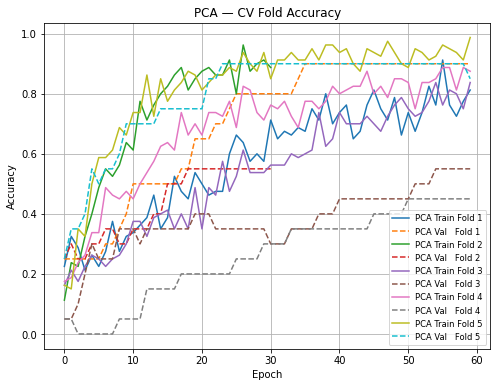

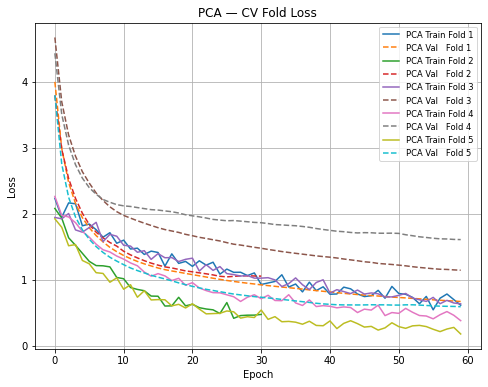

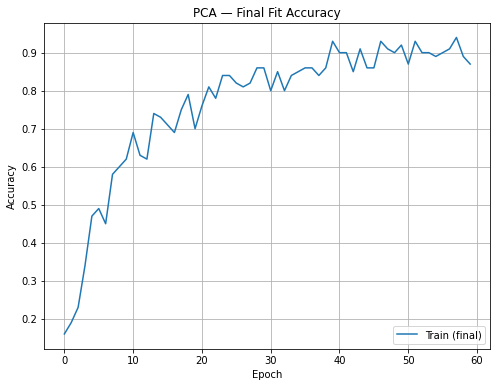

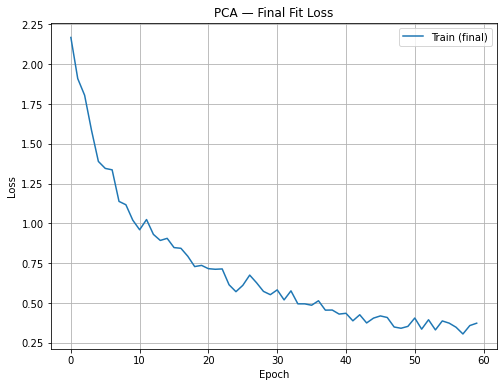

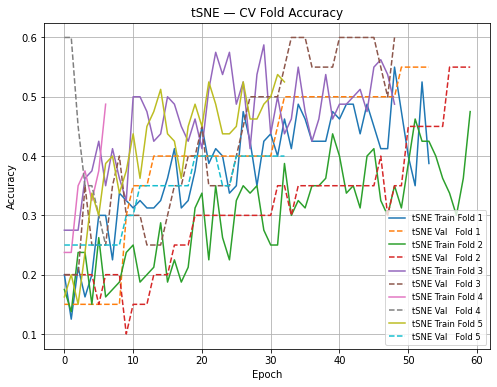

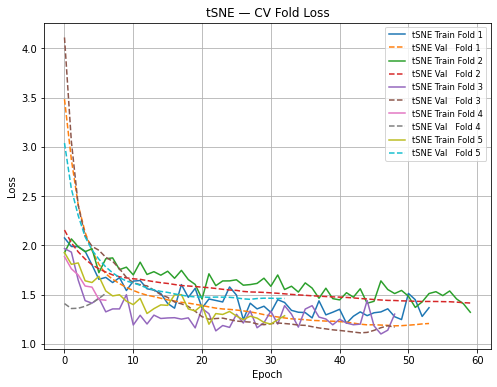

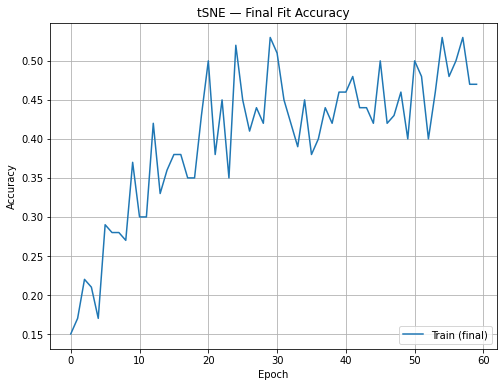

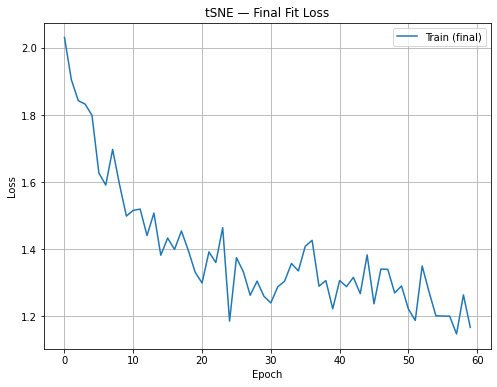

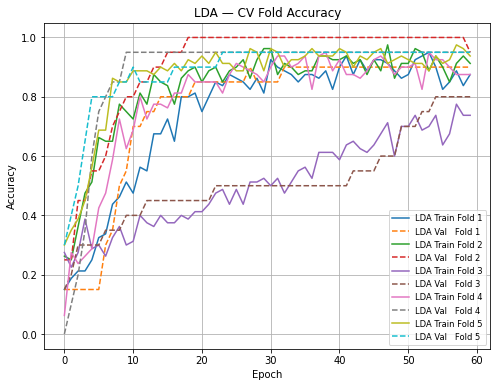

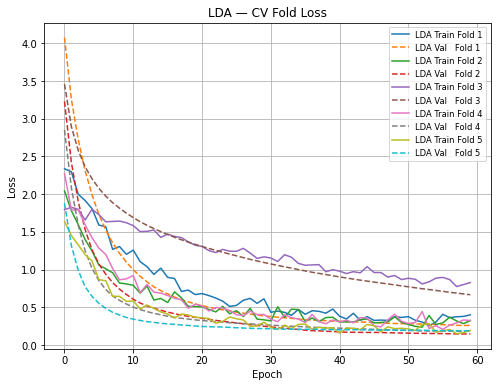

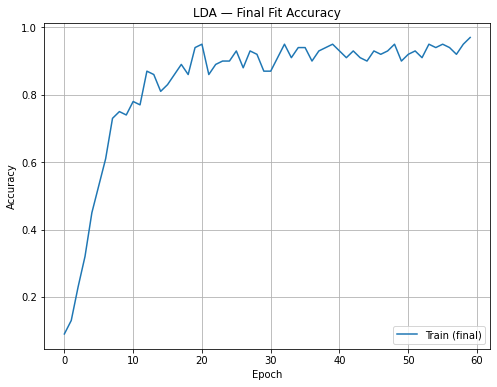

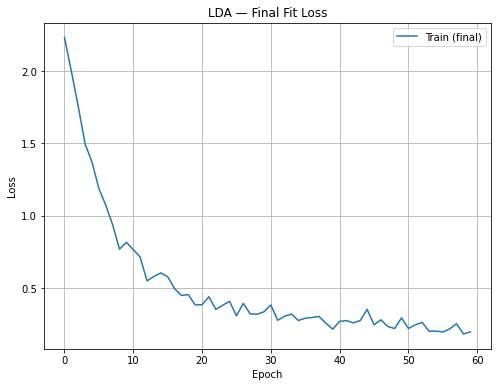

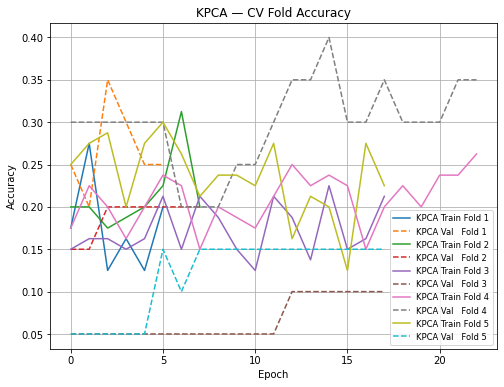

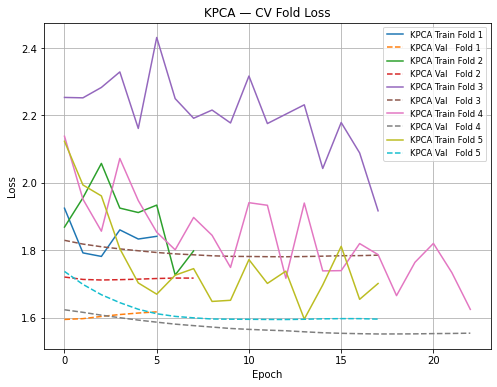

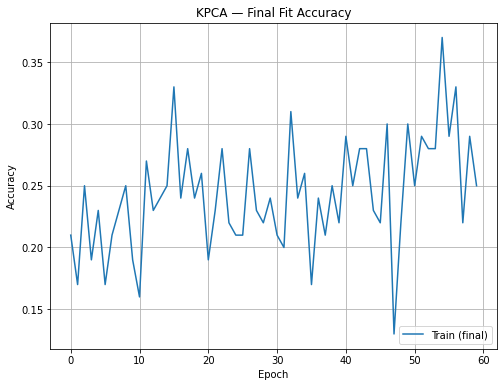

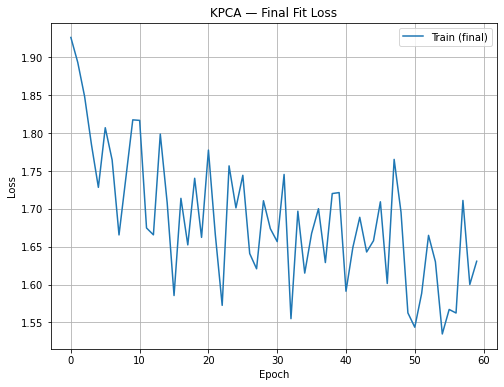

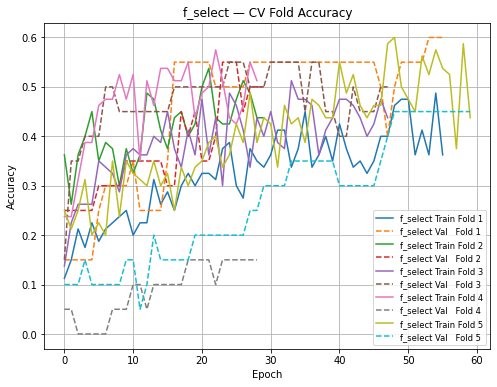

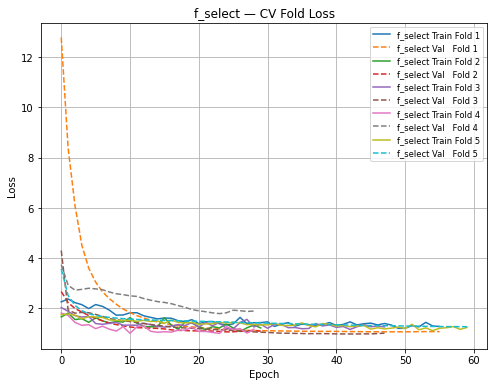

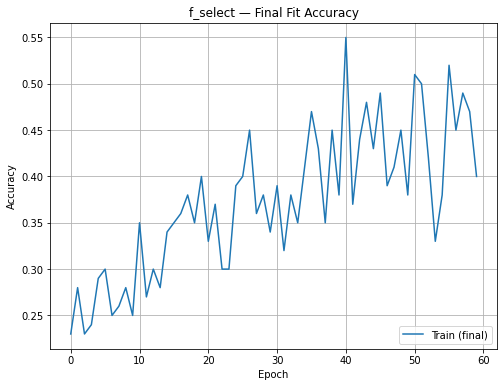

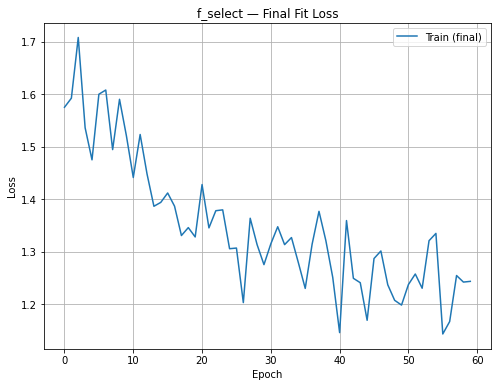

In [5]:
for name, res in results.items():
    histories = res['histories']        # list of History objs, one per fold
    final_history = res['final_history']

    # 1) Plot CV-fold training & validation accuracy
    plt.figure(figsize=(8, 6))
    for fold, h in enumerate(histories, start=1):
        plt.plot(h.history['accuracy'],             label=f'{name} Train Fold {fold}')
        plt.plot(h.history['val_accuracy'], linestyle='--', label=f'{name} Val   Fold {fold}')
    plt.title(f'{name} — CV Fold Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.show()

    # 2) Plot CV-fold training & validation loss
    plt.figure(figsize=(8, 6))
    for fold, h in enumerate(histories, start=1):
        plt.plot(h.history['loss'],             label=f'{name} Train Fold {fold}')
        plt.plot(h.history['val_loss'], linestyle='--', label=f'{name} Val   Fold {fold}')
    plt.title(f'{name} — CV Fold Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)
    plt.show()

    # 3) Plot final-fit training accuracy (no val split)
    plt.figure(figsize=(8, 6))
    plt.plot(final_history.history['accuracy'], label='Train (final)')
    if 'val_accuracy' in final_history.history:
        plt.plot(final_history.history['val_accuracy'], label='Val (final)')
    plt.title(f'{name} — Final Fit Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # 4) Plot final-fit training loss
    plt.figure(figsize=(8, 6))
    plt.plot(final_history.history['loss'], label='Train (final)')
    if 'val_loss' in final_history.history:
        plt.plot(final_history.history['val_loss'], label='Val (final)')
    plt.title(f'{name} — Final Fit Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()


4/4 [==============================] - 0s 1ms/step


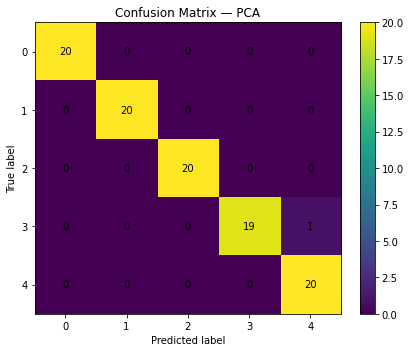

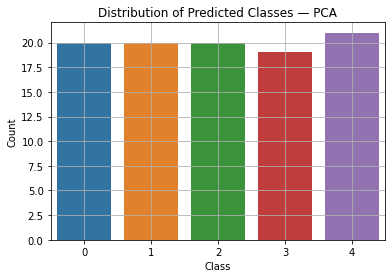

4/4 [==============================] - 0s 1ms/step


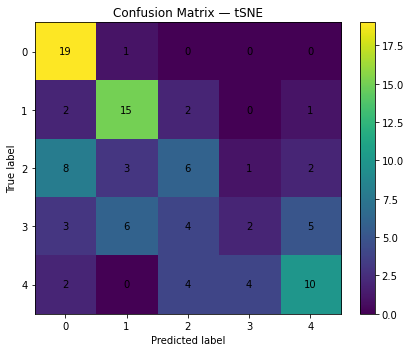

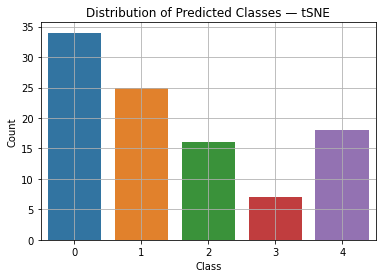

4/4 [==============================] - 0s 1ms/step


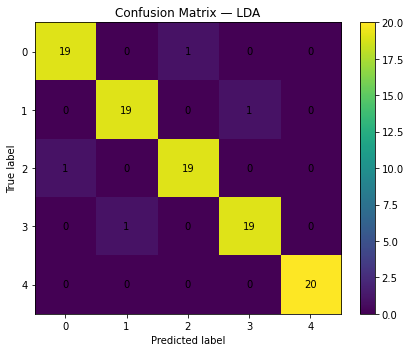

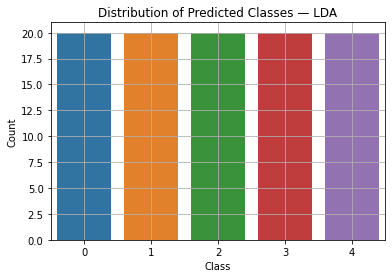

4/4 [==============================] - 0s 1ms/step


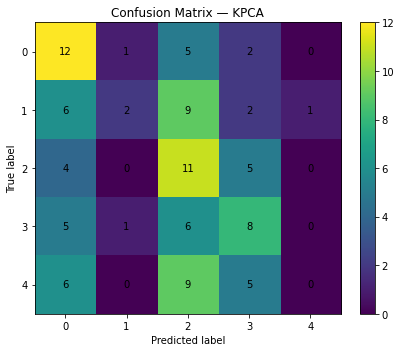

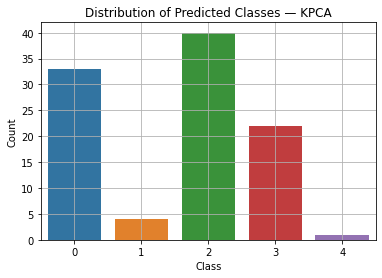

4/4 [==============================] - 0s 1ms/step


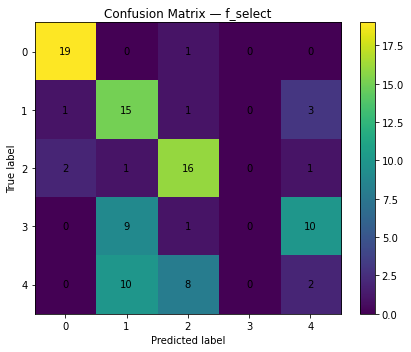

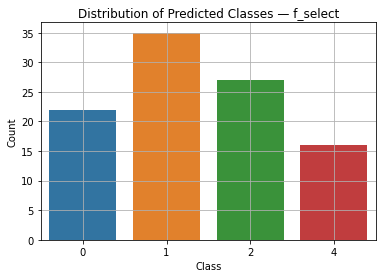

In [10]:
for name, res in results.items():
    model = res['best_model']
    X_full = feature_sets[name]
    y_full = y_sets[name]
    
    # Predict and turn probabilities into class labels
    y_pred_proba = model.predict(X_full)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Compute confusion matrix

    cm = confusion_matrix(y_full, y_pred)
    
    # Plot
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', aspect='auto')
    plt.title(f'Confusion Matrix — {name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    
    # Annotate counts in cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

    # Distribution of predicted classes
    sns.countplot(x=y_pred)
    plt.title(f'Distribution of Predicted Classes — {name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()
